# NN back propagation（神经网络反向传播）

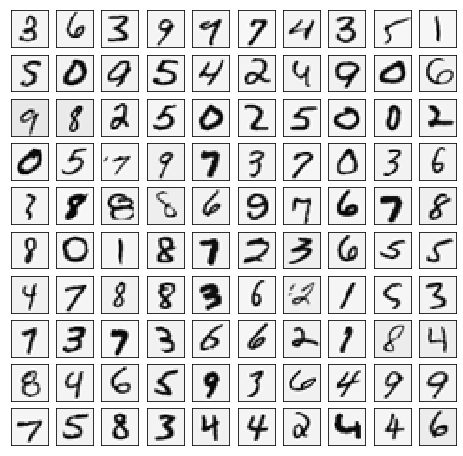

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

def load_data(path, transpose=True): # 准备数据
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

X, _ = load_data('ex4data1.mat')

def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            
plot_100_image(X)
plt.show()

# 代价函数


In [7]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)#增加全部为1的一列
X.shape

(5000, 401)

In [8]:
print(y_raw)
y_raw.shape

[10 10 10 ...  9  9  9]


(5000,)

In [9]:
def expand_y(y):
#     """expand 5000*1 into 5000*10
#     where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i - 1] = 1

        res.append(y_array)
    return np.array(res)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致

In [10]:
y = expand_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# 读取权重

In [20]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

In [12]:
def serialize(a, b):
  
    return np.concatenate((np.ravel(a), np.ravel(b)))
# 序列化2矩阵
# 在这个nn架构中，我们有theta1（25,401），theta2（10,26）

theta = serialize(t1, t2)  # 扁平化参数，25*401+10*26=10285
theta.shape

(10285,)

# feed forward（前向传播）
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="../img/nn_model.png">

In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [14]:
def deserialize(seq):
#     """into ndarray of (25, 401), (10, 26)"""
    return seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

In [15]:
def feed_forward(theta, X): # ex3 的 forward propagation
    """apply to architecture 400+1 * 25+1 *10
    X: 5000 * 401
    """

    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    a1 = X  # 5000 * 401

    z2 = a1 @ t1.T  # 5000 * 25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)  # 5000*26

    z3 = a2 @ t2.T  # 5000 * 10
    h = sigmoid(z3)  # 5000*10, this is h_theta(X)

    return a1, z2, a2, z3, h  # you need all those for backprop

In [16]:
_, _, _, _, h = feed_forward(theta, X)
h # 5000*10

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

# 代价函数
<img style="float: left;" src="../img/nn_cost.png">

In [18]:
def cost(theta, X, y):
    m = X.shape[0] # get the samples number m
    _, _, _, _, h = feed_forward(theta, X)
    
    res = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))
    return res.sum() / m

cost(theta, X, y)

0.2876291651613189

# 正则化代价函数
<img style="float: left;" src="../img/nn_regcost.png">

In [22]:
def regularized_cost(theta, X, y, learning_rate=1):
    """
    the first column of t1 and t2 is intercept theta, ignore them when you do regularization
    可忽略 t1 和 t2 的第一列, 因为可以忽略偏置项（每一层的 a0）
    """
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]
    
    res = (learning_rate / (2 * m)) * (np.power(t1[:, 1:], 2).sum() + np.power(t2[:, 1:], 2).sum())
    
    return cost(theta, X, y) + res

regularized_cost(theta, X, y)

0.38376985909092365

# 反向传播

In [23]:
print(X.shape, y.shape)
print(t1.shape, t2.shape)
print(theta.shape)

(5000, 401) (5000, 10)
(25, 401) (10, 26)
(10285,)


In [25]:
def sigmoid_gradient(z):
    # 为了求每一层误差值 sigma 
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [26]:
def gradient(theta, X, y): # 求 j_theta 对 theta 的偏导数， 对应课件 backpropagation algorithm
    # initialize
    t1, t2 = deserialize(theta)  # t1: (25,401) t2: (10,26)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    a1, z2, a2, z3, h = feed_forward(theta, X)
    
    for i in range(m):
        # 第 i 个样本的相关参数
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)

        hi = h[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = hi - yi  # (1, 10)
        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i, 添加偏置项
        d2i = np.multiply(t2.T @ d3i, sigmoid_gradient(z2i))
        
        delta2 += np.matrix(d3i).T @ np.matrix(a2i)  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i) # (1, 25).T @ (1, 401) -> (25, 401)
    
    delta1  = delta1 / m
    delta2 = delta2 / m
    return serialize(delta1, delta2)

In [27]:
d1, d2 = deserialize(gradient(theta, X, y))
d1.shape, d2.shape

((25, 401), (10, 26))

# 梯度校验
<img style="float: left;" src="../img/gradient_checking.png">

In [28]:
def expand_array(arr):
    """
    [1, 2, 3]
    ==>
    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

In [31]:
def gradient_checking(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon * 2)
        
    theta_matrix = expand_array(theta)  # expand to (10285, 10285)
    epsilon_matrix = np.identity(len(theta)) * epsilon

    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix

    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                                    for i in range(len(theta))])

    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)

    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)

    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

# regularized gradient
Use normal gradient + regularized term


<img style="float: left;" src="../img/nn_reg_grad.png">

In [33]:
def regularized_gradient(theta, X, y, l=1):
    """
    don't regularize theta of bias terms
    忽略偏置项
    """
    m = X.shape[0]
    delta1, delta2 = deserialize(gradient(theta, X, y))
    t1, t2 = deserialize(theta)

    t1[:, 0] = 0 #忽略偏置项
    reg_term_d1 = (l / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)